# Introduction

Acknowledgements

The data was scraped from WineEnthusiast during the week of June 15th, 2017. The code for the scraper can be found here if you have any more specific questions about data collection that I didn't address.

UPDATE 11/24/2017 After feedback from users of the dataset I scraped the reviews again on November 22nd, 2017. This time around I collected the title of each review, which you can parse the year out of, the tasters name, and the taster's Twitter handle. This should also fix the duplicate entry issue.[](http://)

# Index

1. [Understand the dataset](#1.-Understand-the-dataset)
    * [1.1 Basic data cleansing](#1.1-Basic-data-cleansing)
    * [1.2 Feature study](#1.2-Feature-study)
        * [Country](#Country)
        * [Variety(Types of grapes)](#Variety(Types-of-grapes))
        * [Points](#Country)
        * [Price](#Price)        
        

2. [Questions to answer](#2.-Questions-to-answer)
    * [2.1 Does a costly wine means good points?](#2.1-Does-a-costly-wine-means-good-points?) 
    * [2.2 Which countries/regions are more likely to produce good wines?](#2.2-Which-countries/regions-are-more-likely-to-produce-good-wines?)
    * [2.3 Can we deduce good points or price from the type of grapes?](#2.3-Can-we-deduce-good-points-or-price-from-the-type-of-grapes?)
    * [2.4 Are there any characteristics to describe wine of a country and type of grapes?](#2.4-Are-there-any-characteristics-to-describe-wine-of-a-country-and-type-of-grapes?)



In [1]:
'''{
    "tags": [
        "hide_input",
    ]
}'''

'{\n    "tags": [\n        "hide_input",\n    ]\n}'

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
#from nltk.stem import LancasterStemmer, WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.feature_extraction import text
from sklearn.metrics import classification_report

import random

In [3]:
df = pd.read_csv('../input/winemag-data_first150k.csv')

In [4]:
'''df = pd.read_csv(r'C:/eval/wine_review/winemag-data_first150k.csv')
'''

"df = pd.read_csv(r'C:/eval/wine_review/winemag-data_first150k.csv')\n"

## 1. Understand the dataset

Snapshot of the dataset:

In [5]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Number of entries of each variables and data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


Terminology:


Points: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)<br>
Title: the title of the wine review, which often contains the vintage if you're interested in extracting that feature<br>
Variety: the type of grapes used to make the wine (ie Pinot Noir)<br>
Description: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.<br>
Country: the country that the wine is from<br>
Province: the province or state that the wine is from<br>
Region 1: the wine growing area in a province or state (ie Napa)<br>
Region 2: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank<br>
Winery: the winery that made the wine<br>
Designation: the vineyard within the winery where the grapes that made the wine are from<br>
Price: the cost for a bottle of the wine<br>
Taster Name: name of the person who tasted and reviewed the wine<br>
Taster Twitter Handle: Twitter handle for the person who tasted ane reviewed the wine<br>


Basic information about continuous variables of the dataset:

In [7]:
df.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


## 1.1 Basic data cleansing

Cleansing work on
1.  removing column 'Unnamed: 0' <br>
2.  remove duplicated rows

In [8]:
df=df.drop('Unnamed: 0',axis=1)

In [9]:
# Remove duplicated rows
df=df.drop_duplicates()


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97851 entries, 0 to 149639
Data columns (total 10 columns):
country        97848 non-null object
description    97851 non-null object
designation    67955 non-null object
points         97851 non-null int64
price          89131 non-null float64
province       97848 non-null object
region_1       81919 non-null object
region_2       39491 non-null object
variety        97851 non-null object
winery         97851 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 8.2+ MB


Remarks: Parameters without missing entries: description, points, variety, winery

## 1.2 Feature study

### Country

In [11]:
df_country = df['country'].value_counts().to_frame()
df_country.reset_index(inplace=True)
df_country.columns = ['country','counts']

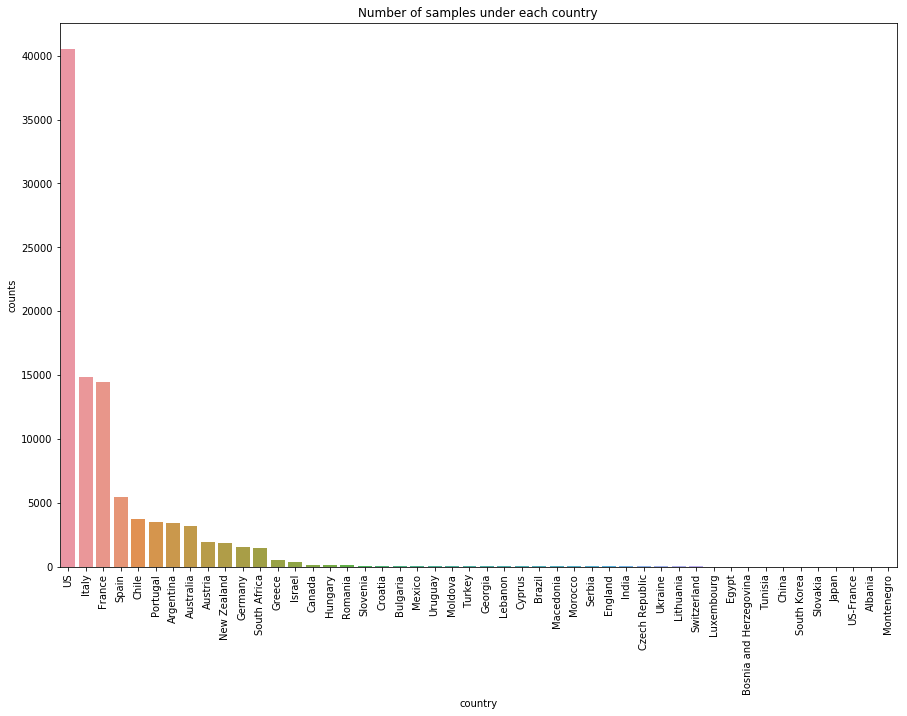

In [12]:
fig, ax = plt.subplots(figsize=(15,10));
sns.barplot(data = df_country, x='country',y='counts',ax=ax).set_title('Number of samples under each country');
plt.xticks(rotation='vertical');

In the dataset around 40% of them were from US, and the sequence of wine producing volumn is different from information indicated in below link:<br>

https://aroundtheworldin80harvests.com/2018/07/30/wine-production-by-country/
    
Country  –  Production in 2017(million hectolitres)<br>
Italy – 39.3 <br>
France – 36.7 <br>
Spain – 33.5 <br>
The United States – 23.3 <br>
Australia – 13.9 <br>
Argentina – 11.8 <br>
China – 11.4 <br>
South Africa – 10.8 <br>
Chile – 9.5 <br>
Germany – 8.1 <br>
World Total – 246.7


This implies possible bias in studying the dataset if there is any features favoring wines from US. To test this I'd set up a hypothesis test on price and points for dataset of US against all other countries.

In [13]:
#form one dataframe only includes US and another excludes US for coparison
df_us = df[df['country']=='US']
df_us.dropna(subset=['price', 'points'],inplace=True)
US_index = df_us.index
df_us = df[df['country']=='US']
US_index = df_us.index
df_nonus = df.drop(US_index)

df_us.dropna(subset=['price', 'points'],inplace=True)
df_nonus.dropna(subset=['price', 'points'],inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Hypothsis test on points:

In [14]:

ttest_ind(df_us['points'], df_nonus['points'],equal_var=False)


Ttest_indResult(statistic=3.171325662692179, pvalue=0.0015180053730552273)

Hypothsis test on price:

In [15]:

ttest_ind(df_us['price'], df_nonus['price'],equal_var=False)

Ttest_indResult(statistic=3.4793602705329802, pvalue=0.0005028789461803278)

Since both p-values are quite low so we cannot say there is no significant difference within two dataset.<br>
One way to reduce the factor of bias in sampling from particular country is to draw samples from countries with ratio following world production but it does not seem to be feasible from the dataset due to limitation of sample size of certain countries with high production volume(e.g. China)

### Variety(Type of grape)

In [16]:
print('According to the dataset, there are {0} types of grapes'.format(df['variety'].nunique()))

According to the dataset, there are 632 types of grapes


Let's take a close look on top 10 types of grapes in the data set.

In [17]:
df_variety = df['variety'].value_counts().to_frame()
df_variety.reset_index(inplace=True)
df_variety.columns=['variety', 'counts']
df_variety_trimmed = df_variety.loc[0:9]



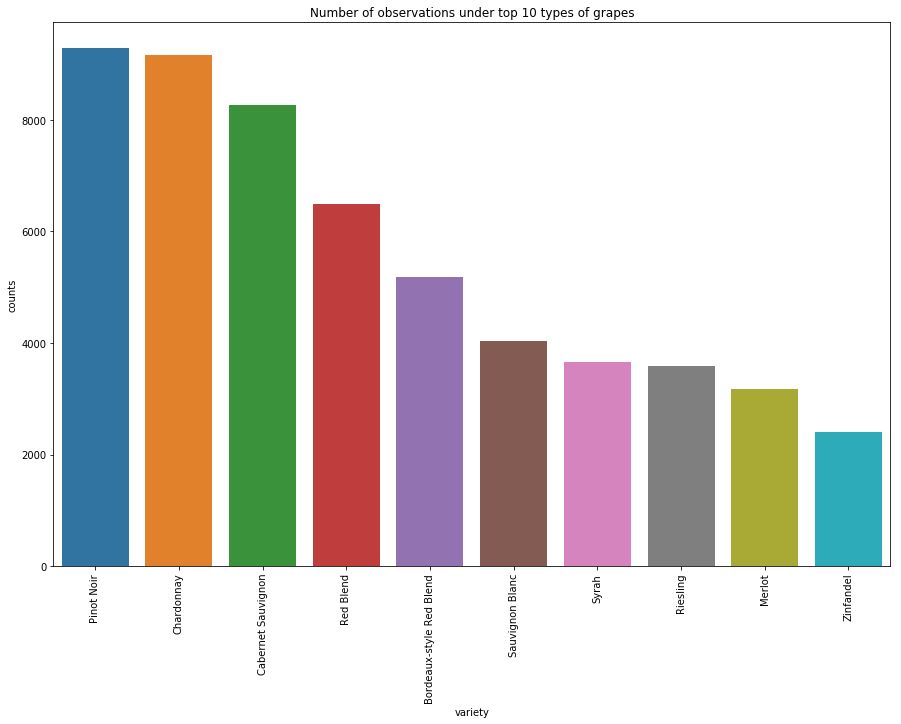

In [18]:
fig, ax = plt.subplots(figsize=(15,10));
sns.barplot(data = df_variety_trimmed, x='variety',y='counts',ax=ax).set_title('Number of observations under top 10 types of grapes');
plt.xticks(rotation='vertical');

It seems Pinot Noir is the most abundent type of grapes but also take a look below integrating countries(top 10 sample quantity):

In [19]:
#make top 10 types of grapes into list
grape_list=list(df_variety_trimmed['variety'])

In [20]:
#make list of top 10 countries(wine production)

country_trimmed = df_country.loc[0:9]
country_list=list(country_trimmed['country'])

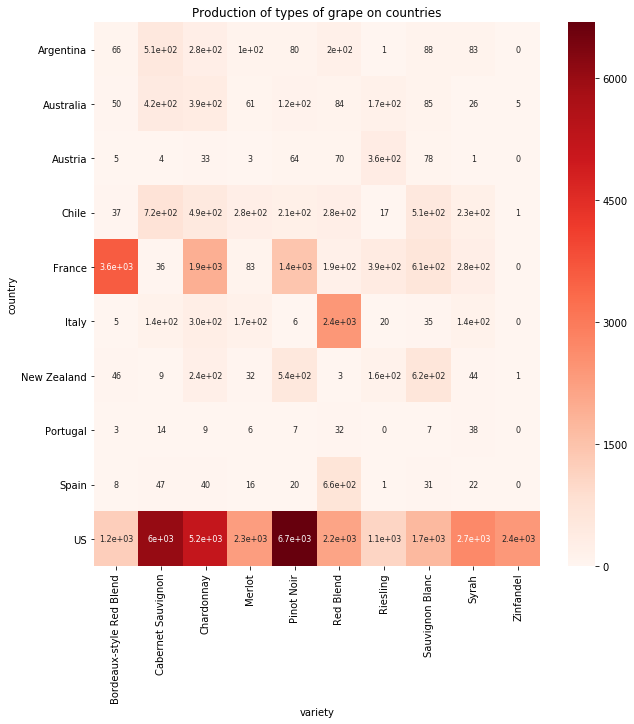

In [21]:
#generate heatmap
df_top_variety_country= df[df['variety'].isin(grape_list)]
df_top_variety_country = df_top_variety_country[df_top_variety_country['country'].isin(country_list)]
df_top_variety_country = df_top_variety_country.groupby(['country','variety']).size().unstack(level=-1)
df_top_variety_country.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize=(10,10));
sns.heatmap(df_top_variety_country,cmap = 'Reds',annot=True, annot_kws={"size": 8},ax=ax).set_title('Production of types of grape on countries');

Above heatmap shows the dataset is biased to wine produced in US which produces lots of Pinot Noir

------------------------------------------------------------------

## Points

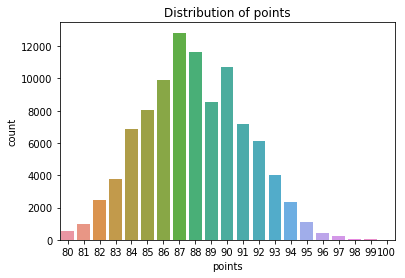

In [22]:
sns.countplot(df['points']).set_title('Distribution of points');

In [23]:
print("It may be interesting to know what wines score the highest points. There are totally {} wines scoring 100 points.".format(df[df['points']==100]['points'].count()))
print("Details are shown below:")

It may be interesting to know what wines score the highest points. There are totally 11 wines scoring 100 points.
Details are shown below:


In [24]:
df[df['points']==100].sort_values(['country','designation'])

,country,description,designation,points,price,province,region_1,region_2,variety,winery
19355,Australia,Not a Cellar Selection in the traditional sens...,Rare,100,300.0,Victoria,Rutherglen,NaN,Muscat,Chambers Rosewood Vineyards
26296,France,A wine that has created its own universe. It h...,Clos du Mesnil,100,1400.0,Champagne,Champagne,NaN,Chardonnay,Krug
2145,France,"Full of ripe fruit, opulent and concentrated, ...",NaN,100,848.0,Bordeaux,Pessac-Léognan,NaN,Bordeaux-style White Blend,Château Haut-Brion
28954,Italy,"This small, family-run estate in the heart of ...",Guado de' Gemoli,100,195.0,Tuscany,Bolgheri Superiore,NaN,Red Blend,Giovanni Chiappini
24151,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,NaN,Merlot,Tenuta dell'Ornellaia
111087,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,NaN,Prugnolo Gentile,Avignonesi
19354,US,"In a stunning lineup of Cayuse Syrahs, the En ...",En Chamberlin Vineyard,100,65.0,Oregon,Walla Walla Valley (OR),Oregon Other,Syrah,Cayuse
92916,US,A perfect score has to be considered in the co...,Hillside Select,100,215.0,California,Stags Leap District,Napa,Cabernet Sauvignon,Shafer
98647,US,"A spectacular Pinot Noir, but a very young one...",Litton Estate Vineyard,100,100.0,California,Russian River Valley,Sonoma,Pinot Noir,Williams Selyem
114272,US,Impossibly aromatic. Hard to imagine greater c...,Red Wine,100,245.0,California,Rutherford,Napa,Cabernet Blend,Sloan


In [25]:
df_price_notna=df[df['price'].notna()]

## Price

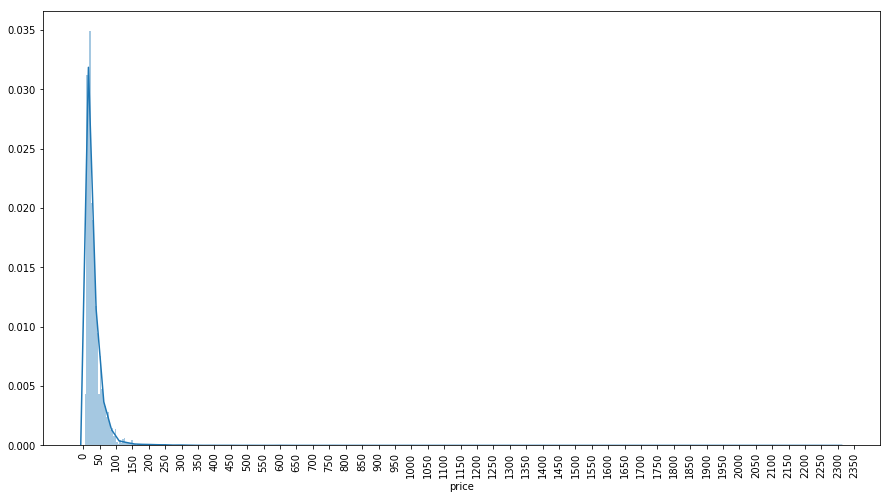

In [26]:
fig, ax = plt.subplots(figsize=(15,8));
sns.distplot(df_price_notna['price'],bins=500,ax=ax);
plt.xticks(np.arange(0, 2400, step=50),rotation='vertical');


In [27]:
df['price'].describe()

count    89131.000000
mean        33.658783
std         37.670180
min          4.000000
25%         16.000000
50%         25.000000
75%         40.000000
max       2300.000000
Name: price, dtype: float64

## Winery

In [28]:
df_winery = df['winery'].value_counts().to_frame()
df_winery.reset_index(inplace=True)
df_winery.columns=['winery', 'counts']
#df_winery_trimmed = df_variety.loc[0:9]
df_winery

,winery,counts
0,Williams Selyem,235
1,Testarossa,171
2,Chateau Ste. Michelle,156
3,Columbia Crest,152
4,DFJ Vinhos,148
5,Concha y Toro,132
6,Georges Duboeuf,129
7,Kendall-Jackson,125
8,Joseph Drouhin,121
9,Trapiche,120


------------------------------------------------------------------

## 2. Questions to answer

After studied basic features, here it pops out some questions in my mind,
1. Does a costly wine means good points?
2. Which country/regions are more likely to produce good wines?
3. Can we deduce good points or price from the type of grapes?
4. Any characteristics to describe wine of a country
4. 

### 2.1 Does a costly wine means good points?

I tried to put price and points together to see if there is a clear relationship:

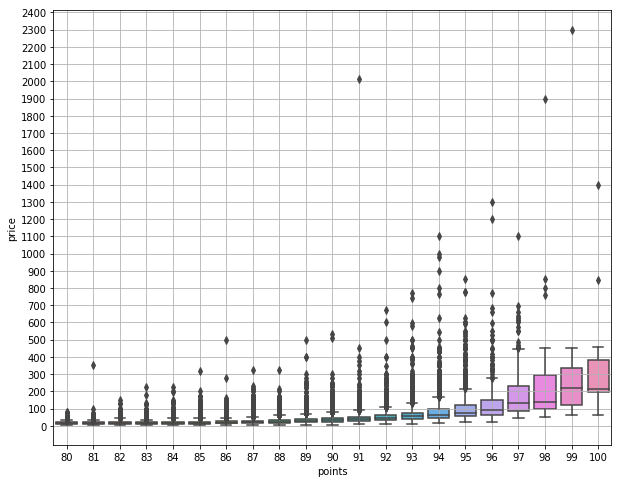

In [29]:
fig, ax = plt.subplots(figsize=(10,8));
sns.boxplot(data=df,x='points',y='price');
plt.yticks(np.arange(0, 2500, step=100));
plt.grid();

In [30]:
df.corr()

,points,price
points,1.000000,0.447355
price,0.447355,1.000000


Although fairly good wine can be sold at low cost, we do not see wines scoring very high are sold at cheap prices.

Want some affordable and good quality wine? Here is picked list for reference:

In [31]:
df_cheapNgood = df[(df['price']<=50) & 
                   (df['points']>=96)].sort_values(['country','points','price'])
df_cheapNgood

,country,description,designation,points,price,province,region_1,region_2,variety,winery
83001,Argentina,This wine takes you on a trip to an outer wine...,Gran Corte Las Divas Vineyard,96,50.0,Mendoza Province,Tupungato,NaN,Bordeaux-style Red Blend,Riglos
17162,France,"A wine packed with noble rot, giving richness ...",Huebuhl,96,47.0,Alsace,Alsace,NaN,Alsace white blend,Domaine Marcel Deiss
2459,France,A tightly coiled rich wine that has great acid...,NaN,96,50.0,Bordeaux,Pessac-Léognan,NaN,Bordeaux-style White Blend,Château Malartic-Lagravière
127498,Germany,Bottling a TBA in this format makes great sens...,Wehlener Sonnenuhr Trockenbeerenauslese Goldkap,96,49.0,Mosel-Saar-Ruwer,NaN,NaN,Riesling,Dr. Loosen
10541,Italy,This stunning Chianti Classico has an intense ...,NaN,96,27.0,Tuscany,Chianti Classico,NaN,Red Blend,Isole e Olena
2449,Italy,"Enticing perfumed berry, violet, new leather a...",NaN,96,50.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese,Baricci
37932,Italy,Poggio Nardone offers an absolutely gorgeous B...,NaN,96,50.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Poggio Nardone
10601,Spain,"One look, one whiff, one taste and you're swoo...",Gran Reserva 904,96,50.0,Northern Spain,Rioja,NaN,Red Blend,La Rioja Alta
56971,US,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Syrah,Rulo
65333,US,What a roll Fess Parker Winery is on with thei...,Bien Nacido Vineyard,96,28.0,California,Santa Barbara County,Central Coast,Chardonnay,Fess Parker


## 2.2 Which countries/regions are more likely to produce good wines?


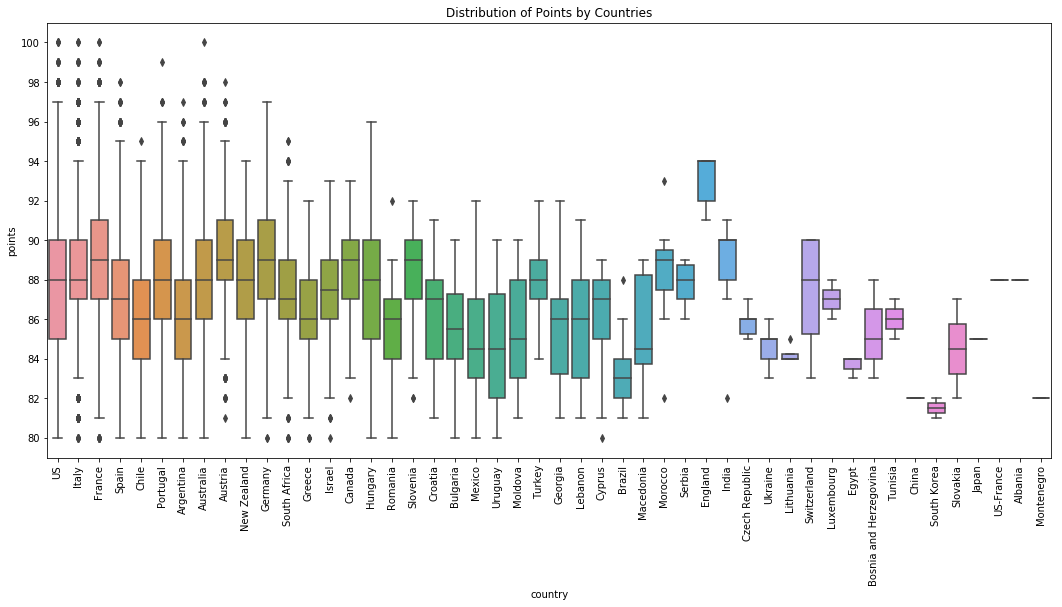

In [32]:
fig, ax = plt.subplots(figsize=(18,8));
sns.boxplot(data = df,x = 'country', y='points',ax=ax,order=df_country['country']).set_title('Distribution of Points by Countries');
plt.xticks(rotation='vertical');
plt.yticks(np.arange(80, 102, step=2));


In [33]:
best_regions=df.groupby(['region_1']).median().sort_values(by='points',ascending=False)
best_regions.reset_index(inplace=True)

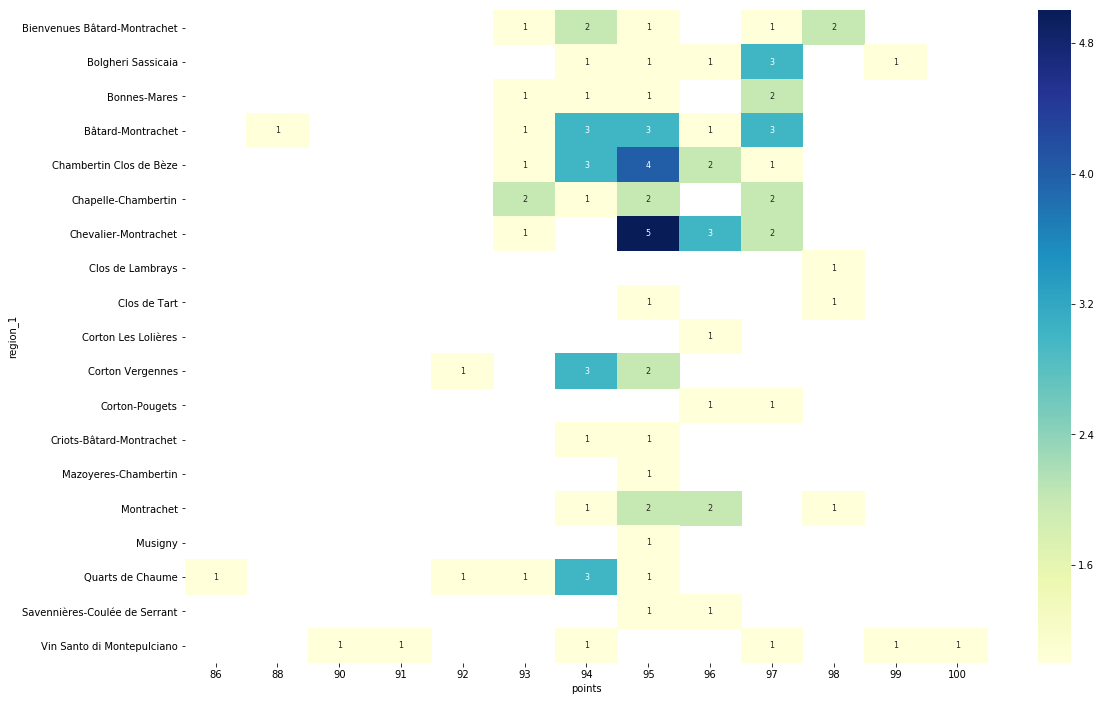

In [34]:
hm_best_regions=df[df['region_1'].isin(list(best_regions['region_1'].iloc[0:19]))]
hm_best_regions = hm_best_regions.groupby(['region_1','points']).size().unstack()

fig, ax = plt.subplots(figsize=(18,12));
sns.heatmap(hm_best_regions,cmap = 'YlGnBu',annot=True, annot_kws={"size": 8},ax=ax);

In [35]:
df_good_region_1=df.groupby('region_1').size().to_frame().reset_index()
df_good_region_1.columns=['region_1','count']

In [36]:
df_good_region_1=pd.merge(df_good_region_1,best_regions,on='region_1')
df_good_region_1=df_good_region_1[(df_good_region_1['count']>50) & (df_good_region_1['points']>90)].sort_values(['points','price'],ascending=False)

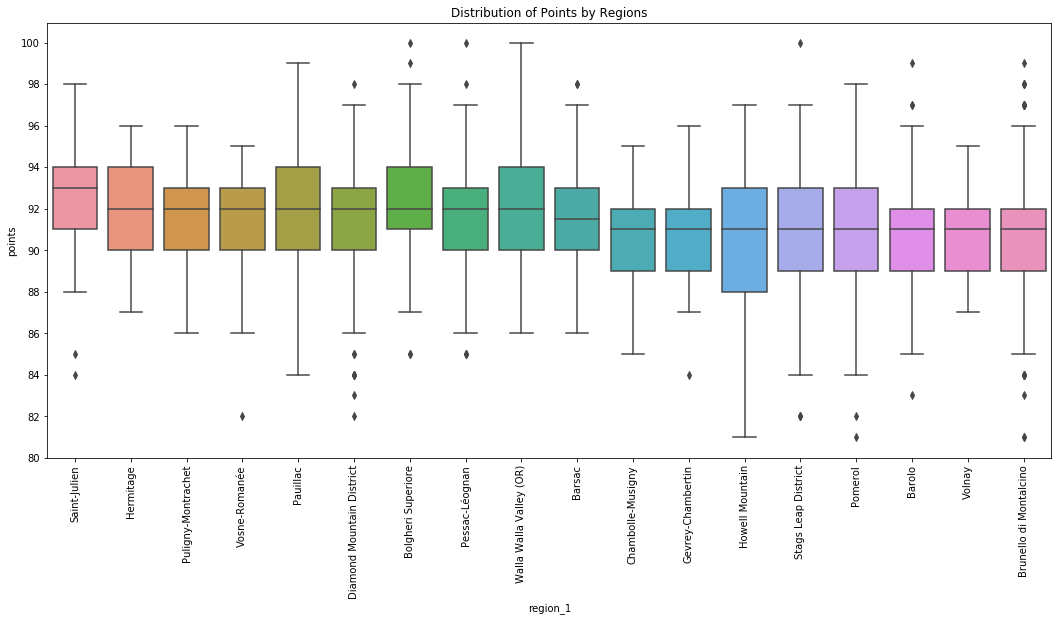

In [37]:
df_temp=df[df['region_1'].isin(list(df_good_region_1['region_1'].iloc[0:18]))]
fig, ax = plt.subplots(figsize=(18,8));
sns.boxplot(data = df_temp,x = 'region_1', y='points',
            order = list(df_good_region_1['region_1'].iloc[0:18]),ax=ax).set_title('Distribution of Points by Regions');

plt.xticks(rotation='vertical');
plt.yticks(np.arange(80, 102, step=2));

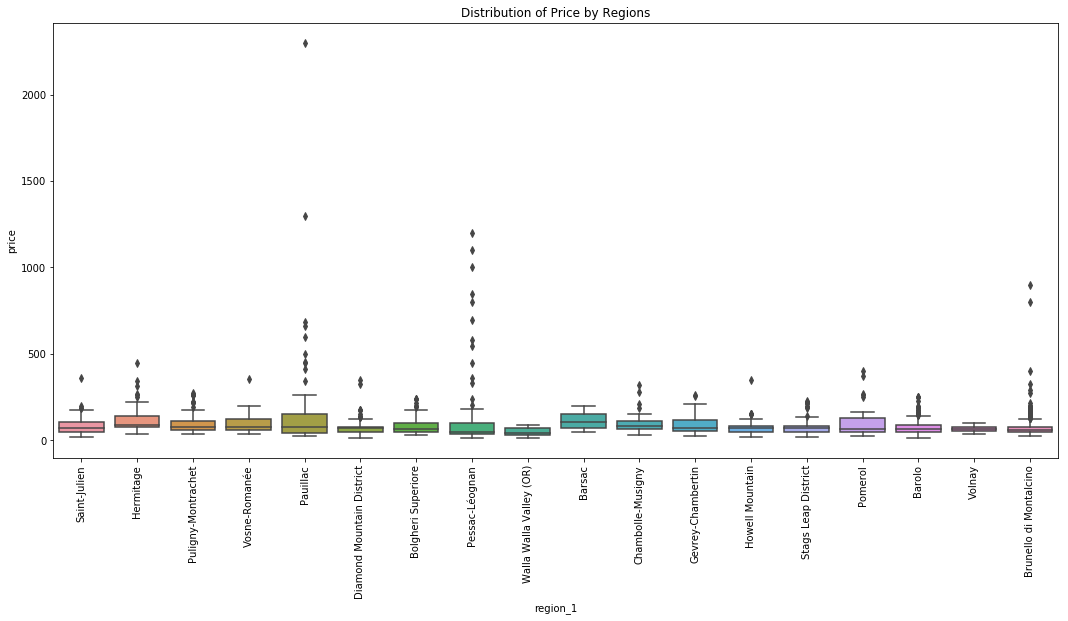

In [38]:
df_temp=df[df['region_1'].isin(list(df_good_region_1['region_1'].iloc[0:18]))]
fig, ax = plt.subplots(figsize=(18,8));
sns.boxplot(data = df_temp,x = 'region_1', y='price',order = list(df_good_region_1['region_1'].iloc[0:18]),ax=ax).set_title('Distribution of Price by Regions');

plt.xticks(rotation='vertical');

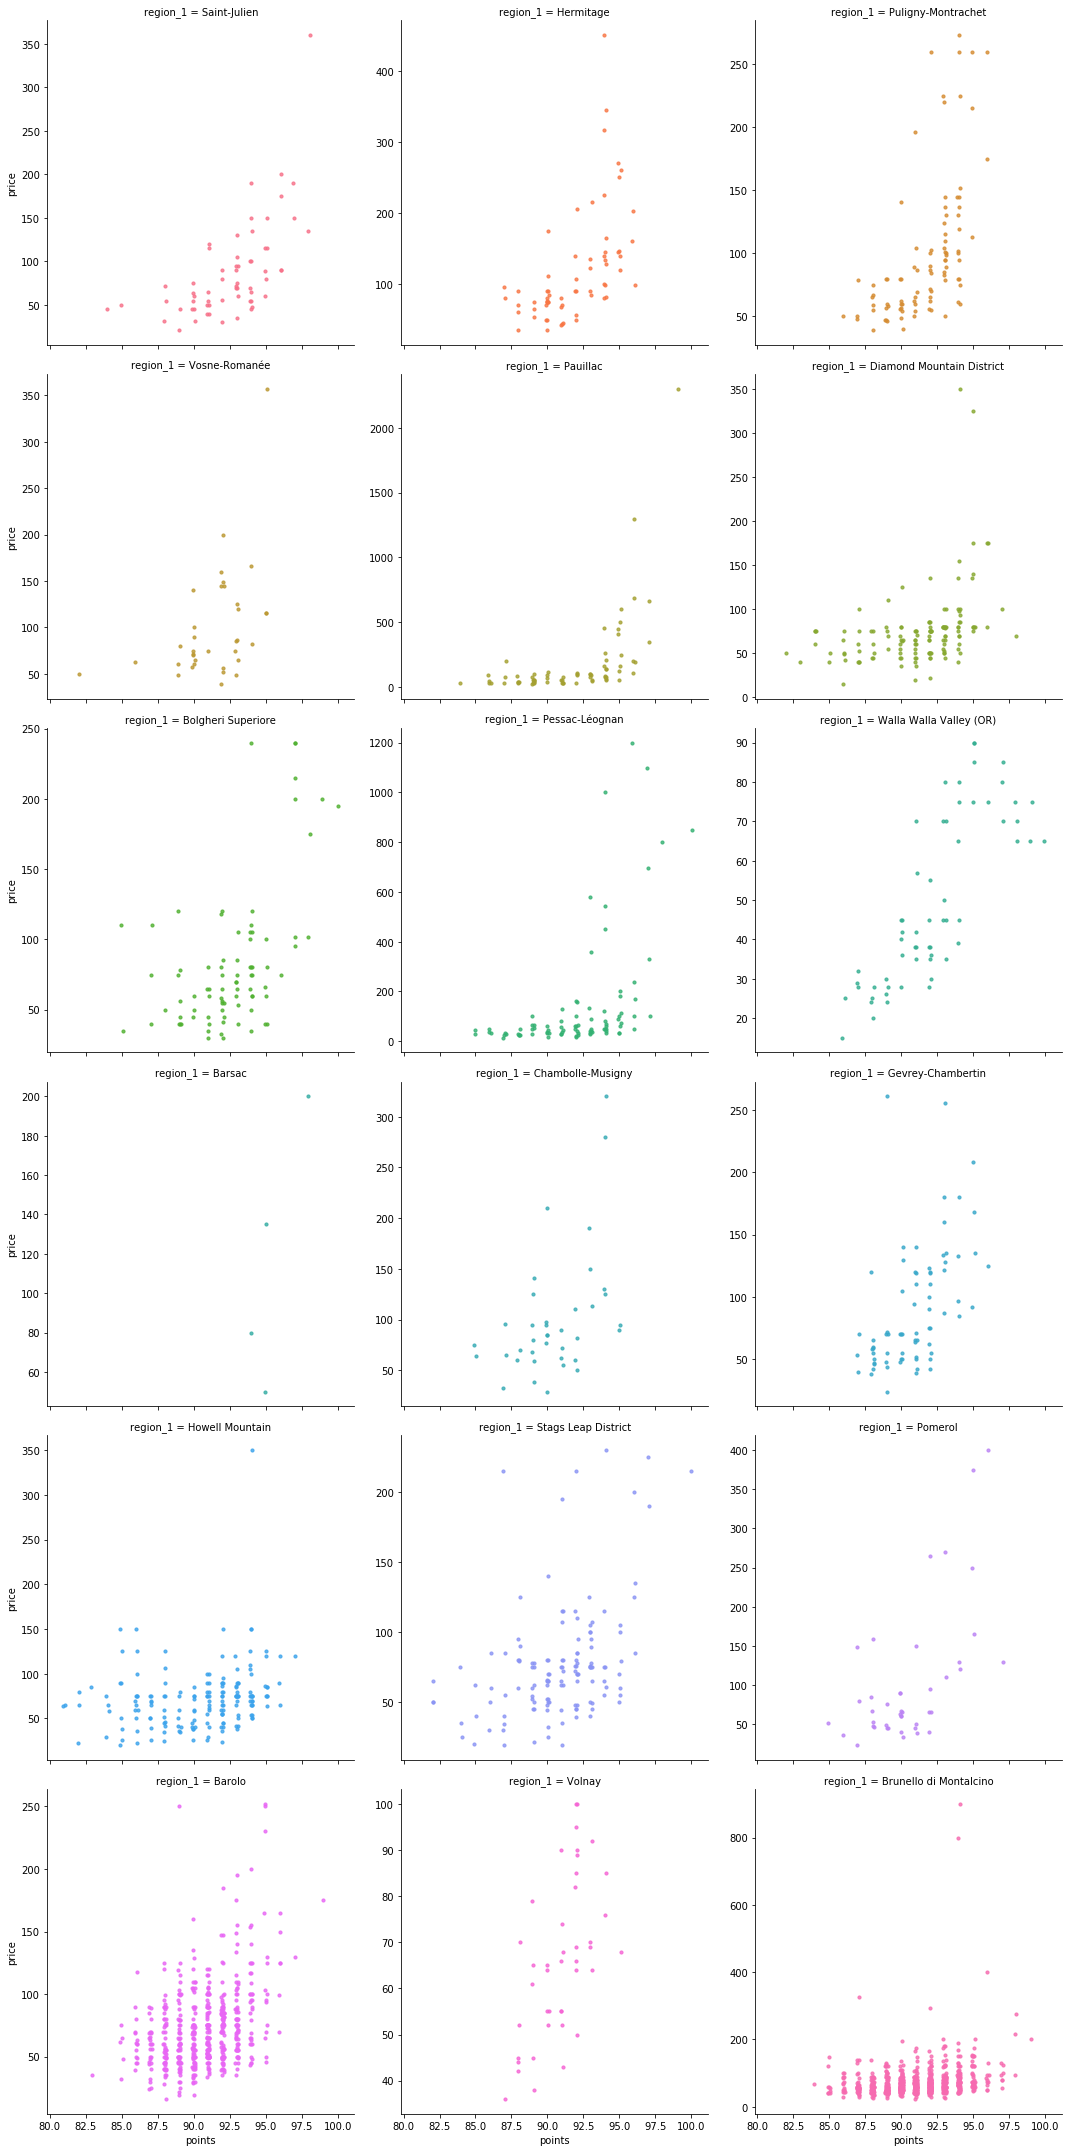

In [39]:
sns.lmplot(data=df_temp,x='points',y='price',hue='region_1',col='region_1',
           col_order=list(df_good_region_1['region_1'].iloc[0:18]),col_wrap =3,
           hue_order=list(df_good_region_1['region_1'].iloc[0:18]),
           scatter_kws={'alpha':0.8,"s": 10},x_jitter=.1,fit_reg=False,sharey=False);


*lots of wine produced in Barsac does not mention price

You may see that wines from France has narrower density band than other countries, which means price distribution of wine is the widest.

### 2.3 Can we deduce good points or price from the type of grapes?

In [41]:
df_variety = df['variety'].value_counts().to_frame().sort_values(by='variety',ascending=False)
df_variety.reset_index(inplace=True)
df_variety.columns=['variety', 'counts']
df_variety_trimmed = df_variety.loc[0:9]

grape_list=list(df_variety_trimmed['variety'])


In [42]:
df_trimmed=df[df['variety'].isin(grape_list)]


In [43]:
grape_list_median = list(df_trimmed.groupby('variety').median().
     sort_values(by='points',ascending=False).reset_index()['variety'])

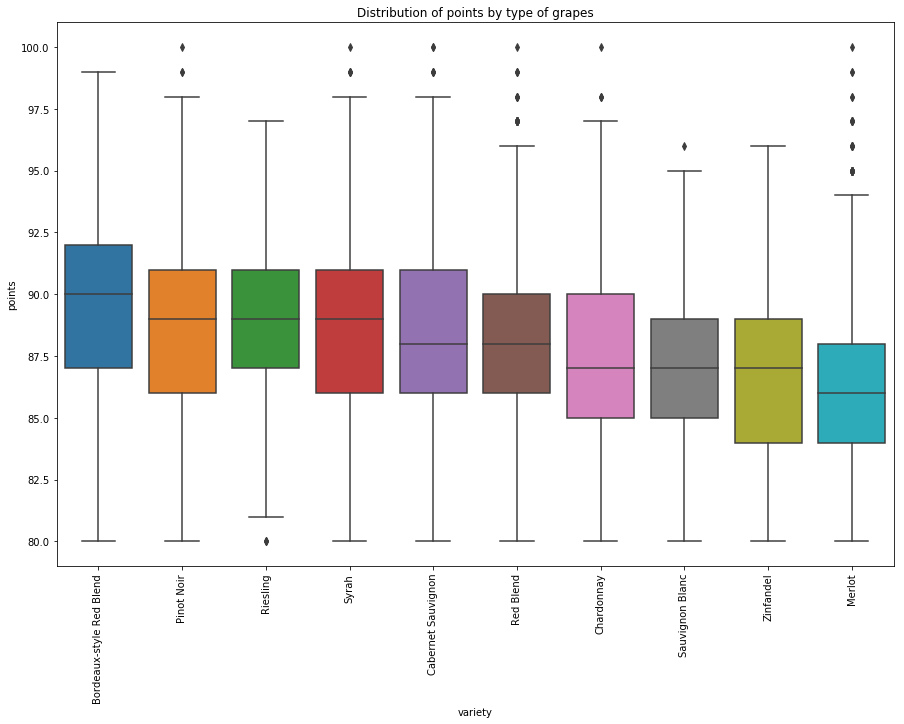

In [44]:
fig, ax = plt.subplots(figsize=(15,10));
sns.boxplot(data = df_trimmed, x='variety', y='points', order = grape_list_median, ax=ax).set_title(
    'Distribution of points by type of grapes')
plt.xticks(rotation='vertical');

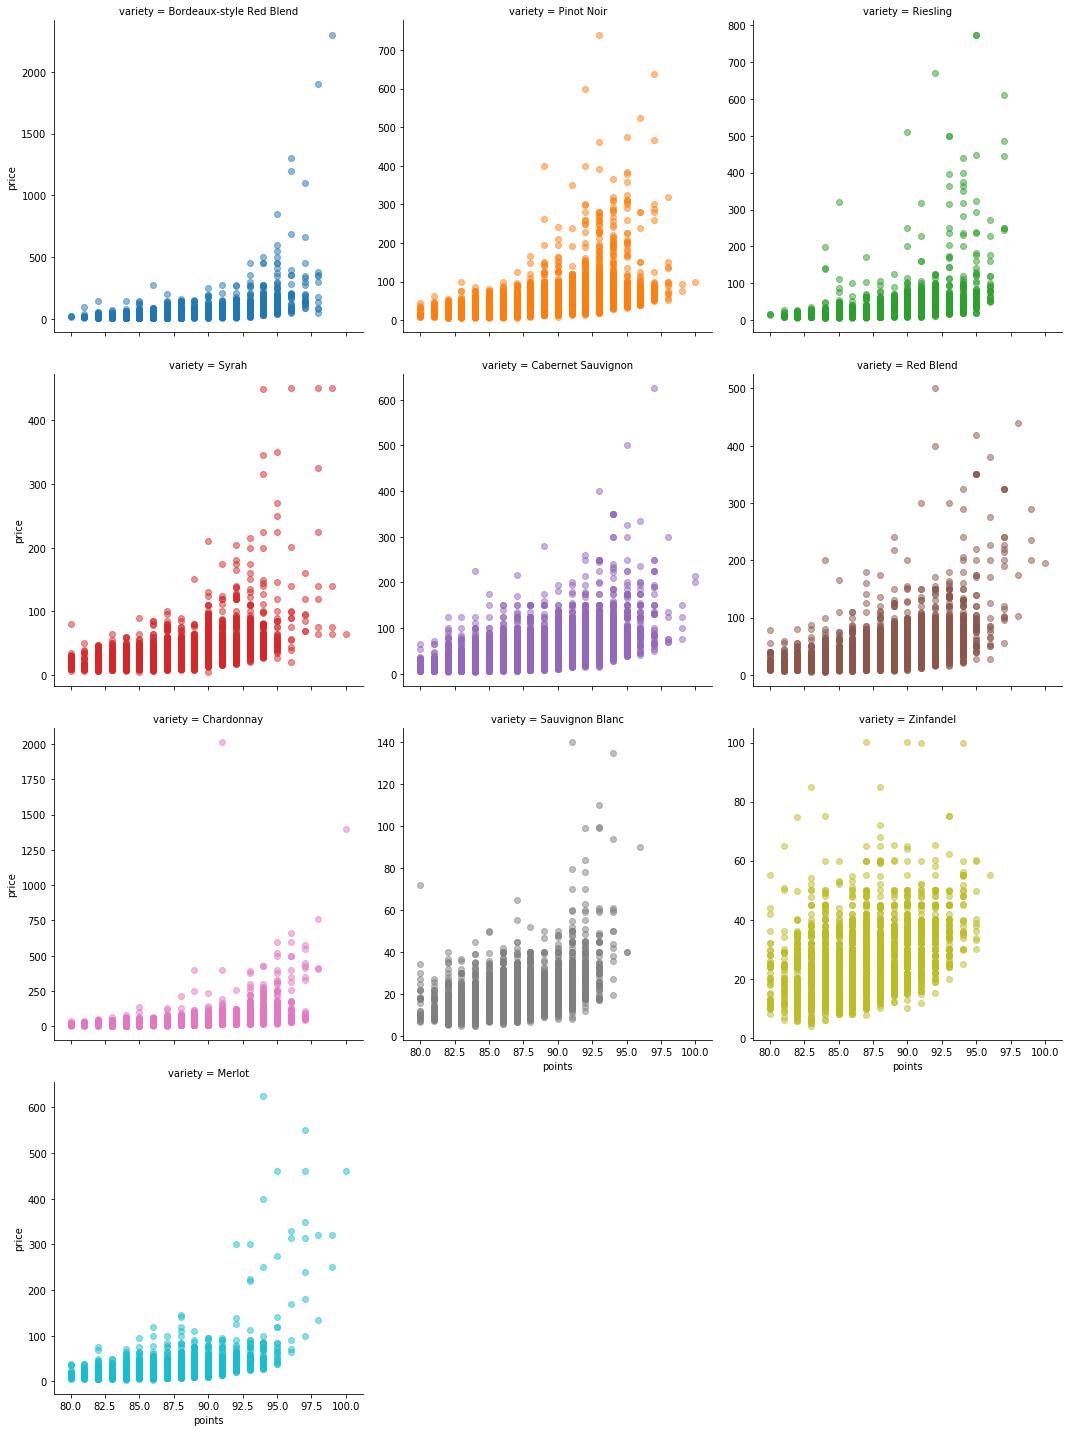

In [45]:
sns.lmplot(data=df_trimmed,x='points',y='price',hue='variety',
           col='variety',col_wrap =3,col_order = grape_list_median ,
           hue_order = grape_list_median ,scatter_kws={'alpha':0.5},
           y_jitter=.2,fit_reg=False,sharey=False);


## 2.4 Are there any characteristics to describe wine of a country and type of grapes

In [46]:
#form dataframe
df_word = df[['description','country','variety']]
df_word = df_word[df_word['variety'].notna()]
df_word = df_word[df_word['variety'].isin(grape_list)]
df_word.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55251 entries, 0 to 149639
Data columns (total 3 columns):
description    55251 non-null object
country        55249 non-null object
variety        55251 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


In [47]:
#change to lower case
df_word['description'] = df_word['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_word['description'].head()


0    this tremendous 100% varietal wine hails from ...
2    mac watson honors the memory of a wine once ma...
3    this spent 20 months in 30% new french oak, an...
8    this re-named vineyard was formerly bottled as...
9    the producer sources from two blocks of the vi...
Name: description, dtype: object

In [48]:
#remove punctuation
df_word['description'] = df_word['description'].str.replace('[^\w\s]','')
df_word['description'].head()


0    this tremendous 100 varietal wine hails from o...
2    mac watson honors the memory of a wine once ma...
3    this spent 20 months in 30 new french oak and ...
8    this renamed vineyard was formerly bottled as ...
9    the producer sources from two blocks of the vi...
Name: description, dtype: object

In [49]:
#remove stopwords
stopword = stopwords.words('english')
df_word['description'] = df_word['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
df_word['description'].head()


0    tremendous 100 varietal wine hails oakville ag...
2    mac watson honors memory wine made mother trem...
3    spent 20 months 30 new french oak incorporates...
8    renamed vineyard formerly bottled delancellott...
9    producer sources two blocks vineyard wineone h...
Name: description, dtype: object

In [50]:
#remove most frequent words
freq = ' '.join(df_word['description'])
freq=pd.Series(freq.split())
freq.value_counts()[:20]


flavors    30659
wine       30560
fruit      20388
tannins    13694
finish     13416
cherry     12011
acidity    11794
ripe       10739
black       9952
aromas      9935
dry         9673
palate      9441
oak         9144
drink       9141
rich        8433
sweet       7625
red         6976
spice       6854
notes       6808
soft        6646
dtype: int64

I decide to trim away top 5 words since they do not indicate too much about wine characteristics

In [51]:
#Form list of top 3 words
most_freq_words=freq.value_counts()[:2]

#Remove words in top 5 words
df_word['description'] = df_word['description'].apply(lambda x: " ".join(x for x in x.split() if x not in most_freq_words))
df_word['description'].head()


0    tremendous 100 varietal hails oakville aged th...
2    mac watson honors memory made mother tremendou...
3    spent 20 months 30 new french oak incorporates...
8    renamed vineyard formerly bottled delancellott...
9    producer sources two blocks vineyard wineone h...
Name: description, dtype: object

Below I will use WordCloud to show the most common words(bigger words means appear more frequently)

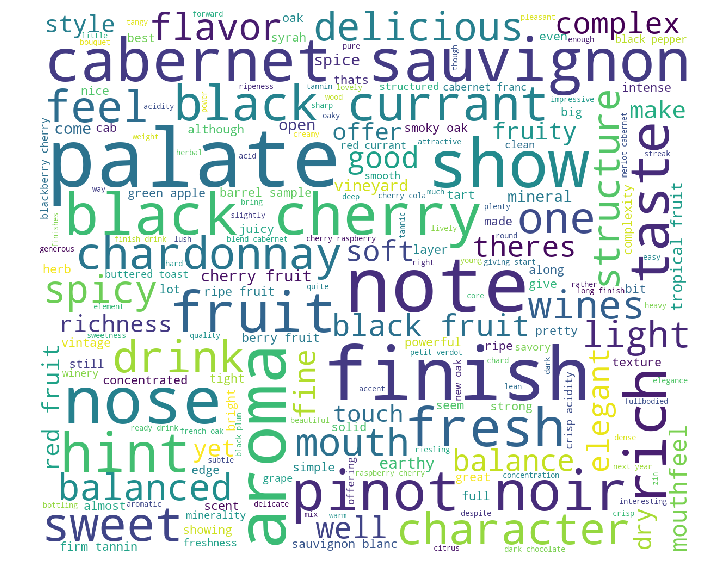

In [52]:
wordcloud = WordCloud(background_color='white',max_words=200,max_font_size=150, width=1200, height=1000).generate(" ".join(df_word['description'].astype(str)))

fig = plt.figure(figsize = (12,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [53]:
#Stemmerization
stemmer = PorterStemmer()
df_word['description'] = df_word['description'].apply(lambda x: " ".join(stemmer.stem(word) for word in x.split()))
df_word['description'].head()


0    tremend 100 variet hail oakvil age three year ...
2    mac watson honor memori made mother tremend de...
3    spent 20 month 30 new french oak incorpor frui...
8    renam vineyard formerli bottl delancellotti yo...
9    produc sourc two block vineyard wineon high el...
Name: description, dtype: object

In [54]:
#Change to BOW
tfidf=text.TfidfVectorizer(stop_words=stopwords.words('english'))
matrix=tfidf.fit_transform(df_word['description'])


In [55]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(matrix, df_word['variety'], test_size=0.2, random_state=0)  

In [56]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
MultinomialNB()
clf.predict(X_test)

array(['Cabernet Sauvignon', 'Bordeaux-style Red Blend',
       'Cabernet Sauvignon', ..., 'Cabernet Sauvignon',
       'Bordeaux-style Red Blend', 'Pinot Noir'], dtype='<U24')

In [57]:
print (classification_report(y_test, clf.predict(X_test)));

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.83      0.57      0.68      1013
      Cabernet Sauvignon       0.48      0.86      0.62      1683
              Chardonnay       0.65      0.97      0.78      1897
                  Merlot       0.00      0.00      0.00       599
              Pinot Noir       0.63      0.89      0.74      1905
               Red Blend       0.67      0.66      0.66      1218
                Riesling       0.99      0.35      0.51       726
         Sauvignon Blanc       0.99      0.35      0.52       774
                   Syrah       1.00      0.02      0.04       723
               Zinfandel       1.00      0.08      0.15       513

                accuracy                           0.63     11051
               macro avg       0.72      0.48      0.47     11051
            weighted avg       0.69      0.63      0.57     11051



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### WORDVEC

In [58]:
from gensim.models import Word2Vec

In [59]:
#from gensim.utils import simple_preprocess

In [60]:
doc = df_word['description'].apply(lambda x:x.split())

w2v_model = Word2Vec(size=300, window=10, min_count=20, sg=1)
w2v_model.build_vocab(doc)

w2v_model.train(sentences=doc, total_examples=len(doc), epochs=w2v_model.iter)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(5340341, 6503760)

In [61]:
word_vectors = w2v_model.wv
count = 0
for word in word_vectors.vocab:
    if count<10:
        print(word)
        count += 1
    else:
        break

tremend
100
variet
hail
oakvil
age
three
year
oak
juici


In [62]:
wanted_words = []
count = 0
for word in word_vectors.vocab:
    if count<300:
        wanted_words.append(word)
        count += 1
    else:
        break
wanted_vocab = dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)
wanted_vocab

{'tremend': <gensim.models.keyedvectors.Vocab at 0x7f6bd1b86ef0>,
 '100': <gensim.models.keyedvectors.Vocab at 0x7f6bc78ea908>,
 'variet': <gensim.models.keyedvectors.Vocab at 0x7f6bc78ea9e8>,
 'hail': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eaa20>,
 'oakvil': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eaa58>,
 'age': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eaa90>,
 'three': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eaac8>,
 'year': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eab00>,
 'oak': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eab38>,
 'juici': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eab70>,
 'redcherri': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eaba8>,
 'fruit': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eabe0>,
 'compel': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eac18>,
 'hint': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eac50>,
 'caramel': <gensim.models.keyedvectors.Vocab at 0x7f6bc78eac88>,
 'greet': <gensim.models.keyedvectors.

Play around with words:

In [63]:
w1 = "oak"
w2v_model.wv.most_similar(positive=w1, topn=5)

[('vanillin', 0.6257015466690063),
 ('charri', 0.5832073092460632),
 ('oaki', 0.5641204118728638),
 ('vanillasc', 0.5528882741928101),
 ('vanillainfus', 0.546889066696167)]

In [64]:
w1 = "melon"
w2v_model.wv.most_similar(positive=w1, topn=10)

[('cantaloup', 0.7109365463256836),
 ('nectarin', 0.7105147838592529),
 ('honeydew', 0.7027730941772461),
 ('papaya', 0.6818549633026123),
 ('meloni', 0.6727690696716309),
 ('lyche', 0.6704283952713013),
 ('mango', 0.6562682390213013),
 ('tropicalfruit', 0.6558828949928284),
 ('tropic', 0.6540856957435608),
 ('meali', 0.6535516977310181)]

In [65]:
w2v_model.wv.doesnt_match(["milk","espresso","oak"])

/opt/conda/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'oak'

In [66]:
#ref: https://www.kaggle.com/liananapalkova/simply-about-word2vec

## KMean Clustering

In [67]:
from sklearn.cluster import MiniBatchKMeans

In [68]:
kmeans = MiniBatchKMeans(n_clusters = 5, n_init = 5)
kmeans.fit(matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=5, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [69]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 

NameError: name 'num_clusters' is not defined

In [ ]:
clusters = df_word.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (20, 20))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds',annot = True)

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")